In [2]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.3344 - val_loss: 0.1522
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1445 - val_loss: 0.1226
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1206 - val_loss: 0.1104
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1103 - val_loss: 0.1049
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1054 - val_loss: 0.1011
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1019 - val_loss: 0.0987
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0990 - val_loss: 0.0961
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0965 - val_loss: 0.0943
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0951 - val_loss: 0.0930
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0937 - val_loss: 0.0923
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Silhouette Score: 0.10239508002996445
Davies-Bouldin Index: 2.1354143591988177
Calinsk

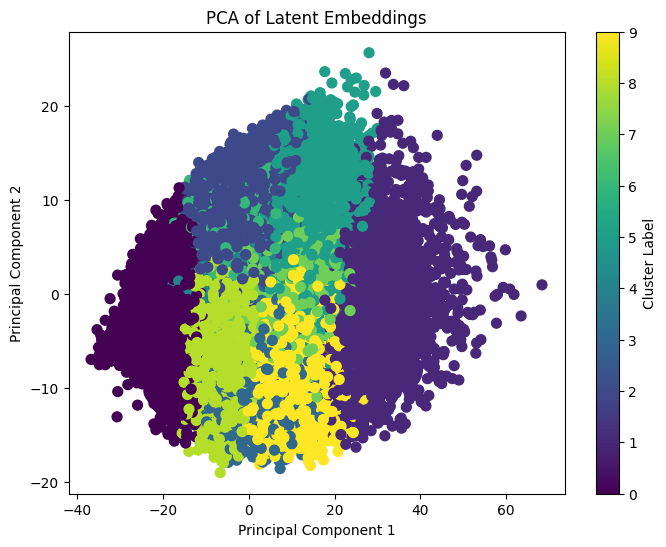

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load MNIST dataset using Hugging Face datasets
dataset = load_dataset("mnist")

# Preprocess the dataset (flattening and normalizing the images)
X_train = dataset['train']['image']
X_train = np.array([np.array(image).flatten() / 255.0 for image in X_train])  # Normalize and flatten the images

X_test = dataset['test']['image']
X_test = np.array([np.array(image).flatten() / 255.0 for image in X_test])  # Normalize and flatten the images

# Define Autoencoder architecture
input_dim = 784  # MNIST images are 28x28, so input is 28x28 = 784
latent_dim = 32  # Latent dimension

# Autoencoder Model
def build_autoencoder(input_dim, latent_dim):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder
    x = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(128, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(x)

    # Autoencoder model
    autoencoder = models.Model(input_layer, decoded)

    # Encoder model for extracting embeddings
    encoder = models.Model(input_layer, encoded)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_dim, latent_dim)

# Compile Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, validation_data=(X_test, X_test))

# Extract latent embeddings using the encoder
embeddings = encoder.predict(X_train)

# Apply K-Means clustering on the embeddings
num_clusters = 10  # Number of clusters (for MNIST, it's 10 digits)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)  # Fit K-Means to the embeddings

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

# Evaluation Metrics
sil_score = silhouette_score(embeddings, cluster_labels)
davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

# Print Evaluation Metrics
print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Visual Inspection using PCA and t-SNE
# 1. PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('PCA of Latent Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# 2. t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('t-SNE of Latent Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()
